In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [ ]:
#please run this cell, it installs MMCV which is required to use deformable convolutions. This takes around 10 mins to complete installation
!pip install mmcv-full


In [3]:
from mmcv.ops import DeformConv2dPack

In [4]:
def G_noise(image,mu,sigma):
  img=np.array(image).astype(np.int16)
  t=np.zeros(img.shape,np.int16)
  img=img+cv2.randn(t,mu,sigma)
  img[img<0]=0
  img[img>255]=255
  img = img.astype(np.uint8)
  #image = PIL.Image.fromarray(img)
  image=img
  return image

def transform(image):
  mu=random.randint(0,15)
  sigma=random.randint(30,90)
  a=G_noise(image,mu,sigma)
  
  return a

In [5]:
#unet Block
def double_conv_layer(in_channels, filter):
  return nn.Sequential(
  DeformConv2dPack(in_channels=in_channels,out_channels=filter,kernel_size=(3,3),padding=(1,1)),
  nn.BatchNorm2d(num_features=filter),
  nn.ReLU(inplace=True),
  DeformConv2dPack(in_channels=filter,out_channels=filter,kernel_size=(3,3),padding=(1,1)),
  nn.BatchNorm2d(num_features=filter),
  nn.ReLU(inplace=True),
  nn.Dropout2d(p=0.1))

  

In [6]:
#defining the network
class unet(nn.Module):
  def __init__(self):
    super(unet,self).__init__()
    self.d1=double_conv_layer(1,32)
    self.p1=nn.MaxPool2d(kernel_size=2,stride=(2,2))
    self.d2=double_conv_layer(32,64)
   
    self.d3=double_conv_layer(64,128)
   
    self.d4=double_conv_layer(128,256)
    self.d5=double_conv_layer(256,512)    
    self.bottle=double_conv_layer(512,1024)

    self.u5=nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=(2,2),stride=(2,2))
    self.ul5=double_conv_layer(1024,512)
    self.u4=nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=(2,2),stride=(2,2))
    self.ul4=double_conv_layer(512,256)
    self.u3=nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(2,2),stride=(2,2))
    self.ul3=double_conv_layer(256,128)

    self.u2=nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(2,2),stride=(2,2))
    self.ul2=double_conv_layer(128,64)

    self.u1=nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=(2,2),stride=(2,2))
    self.ul1=double_conv_layer(64,32)
    
    self.ol=nn.Conv2d(in_channels=32,out_channels=2,kernel_size=(1,1))

    self.sig=nn.Sigmoid()
  def forward(self,X):
    down1=self.d1(X)
    pool1=self.p1(down1)
    
    down2=self.d2(pool1)
    pool2=self.p1(down2)
    
    down3=self.d3(pool2)
    pool3=self.p1(down3)

    down4=self.d4(pool3)
    #print(down4.shape)
    pool4=self.p1(down4)
    
    down5=self.d5(pool4)
    pool5=self.p1(down5)
    
    bottleneck=self.bottle(pool5)
    
    up5=self.u5(bottleneck)
    up5=torch.cat([up5,down5],dim=1)
    up5=self.ul5(up5)
    
    up4=self.u4(up5)
    up4=torch.cat([up4,down4],dim=1)
    up4=self.ul4(up4)
    
    up3=self.u3(up4)
    up3=torch.cat([up3,down3],dim=1)
    up3=self.ul3(up3)

    up2=self.u2(up3)
    up2=torch.cat([up2,down2],dim=1)
    up2=self.ul2(up2)
    
    up1=self.u1(up2)
    up1=torch.cat([up1,down1],dim=1)
    up1=self.ul1(up1)
    
    out=self.ol(up1)
    
    out=self.sig(out)
    
    return out

In [7]:
model=unet()

In [23]:
#transferring the device to GPU
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model=model.to(device)

cuda


In [8]:
#getting the important libraries
import numpy as np
import os
import cv2
import glob
from google.colab.patches import cv2_imshow

In [9]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#please ignore this cell
'''#adding border
def add_border(img: np.array, size_x: int = 128, size_y: int = 128) -> (np.array, int, int):
    """Add border to image, so it will divide window sizes: size_x and size_y"""
    max_y, max_x = img.shape[:2]
    border_y = 0
    if max_y % size_y != 0:
        border_y = (size_y - (max_y % size_y) + 1) // 2
        img = cv2.copyMakeBorder(img, border_y, border_y, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    border_x = 0
    if max_x % size_x != 0:
        border_x = (size_x - (max_x % size_x) + 1) // 2
        img = cv2.copyMakeBorder(img, 0, 0, border_x, border_x, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return img, border_y, border_x


    #preprocessing
def split_img(img: np.array, size_x: int = 128, size_y: int = 128 )-> [np.array]:
    """Split image to parts (little images).
    Walk through the whole image by the window of size size_x * size_y without overlays and
    save all parts in list. Images sizes should divide window sizes.
    """
    max_y, max_x = img.shape[:2]
    parts = []
    curr_y = 0
    # TODO: rewrite with generators.
    while (curr_y + size_y) <= max_y:
        curr_x = 0
        while (curr_x + size_x) <= max_x:
            parts.append(img[curr_y:curr_y + size_y, curr_x:curr_x + size_x])
            curr_x += size_x
        curr_y += size_y
    return parts
    '''

In [10]:
#adding border
def add_border(img: np.array, size_x: int = 128, size_y: int = 128) -> (np.array, int, int):
    """Add border to image, so it will divide window sizes: size_x and size_y"""
    max_y, max_x = img.shape[:2]
    border_y = 0
    if max_y % size_y != 0:
        a = (size_y - (max_y % size_y) + 1)
       # print('a=',a)
        l=0
        r=0
        if a%2!=0:
          l=a//2
          r=a//2
        else:
          l=a//2
          r=(a//2)-1
        #print(l,r)
        img = cv2.copyMakeBorder(img, l, r, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        
    border_x = 0
    if max_x % size_x != 0:
        a = (size_x - (max_x % size_x) + 1)
        l=0
        r=0
        if a%2!=0:
          l=a//2
          r=a//2
        else:
          l=a//2
          r=(a//2)-1
        #print(l,r)
        img = cv2.copyMakeBorder(img, 0, 0, l, r, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return img, border_y, border_x


    #preprocessing
def split_img(img: np.array, size_x: int = 128, size_y: int = 128 )-> [np.array]:
    """Split image to parts (little images).
    Walk through the whole image by the window of size size_x * size_y without overlays and
    save all parts in list. Images sizes should divide window sizes.
    """
    max_y, max_x = img.shape[:2]
    parts = []
    curr_y = 0
    # TODO: rewrite with generators.
    while (curr_y + size_y) <= max_y:
        curr_x = 0
        while (curr_x + size_x) <= max_x:
            parts.append(img[curr_y:curr_y + size_y, curr_x:curr_x + size_x])
            curr_x += size_x
        curr_y += size_y
    return parts

In [11]:
# getting the images from drive for training

get_printed=glob.glob('/content/drive/MyDrive/Siddharth-Binarization/dataset_DIBCO/*')
print(len(get_printed))

images_in=[]
images_gt=[]
for paths in get_printed:
  n=len(glob.glob(paths+"/*_in.png"))
  for i in range(1,n+1):
    if (i<10):
      f_name_in=os.path.join(paths,"0"+str(i)+"_in.png")
      f_name_gt=os.path.join(paths,"0"+str(i)+"_gt.png")
    else :
      f_name_in=os.path.join(paths,str(i)+"_in.png")
      f_name_gt=os.path.join(paths,str(i)+"_gt.png")

    images_in.append(cv2.imread(f_name_in,cv2.IMREAD_GRAYSCALE))
    images_gt.append(cv2.imread(f_name_gt,cv2.IMREAD_GRAYSCALE))

4


In [12]:
size=len(images_in)
for i in range(size):
  a=transform(images_in[i])
  images_in.append(a)
  images_gt.append(images_gt[i])
print(len(images_in))

62


In [13]:
#splitting the images into 128X128 images for training
images_in=np.array(images_in)
images_gt=np.array(images_gt)
print(images_gt.shape)

in_set=[]
gt_set=[]
n=images_in.shape[0]
for i in range(n):
  img_in,_,_=add_border(images_in[i])
  img_gt,_,_=add_border(images_gt[i])
  parts1=split_img(img_in)
  parts2=split_img(img_gt)
  for img in parts1:
    in_set.append(img)
  for img in parts2:
    gt_set.append(img)

(62,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
cd drive/My Drive

/content/drive/My Drive


In [14]:
# resizing the tensor to pytorch format for training in pytorch
in_set=np.array(in_set)
gt_set=np.array(gt_set)
print(gt_set.shape)

num_samples=in_set.shape[0]
in_set.resize((num_samples,1,128,128))
#gt_set.resize((num_samples,1,128,128))
print(in_set.shape)

(4242, 128, 128)
(4242, 1, 128, 128)


In [15]:
#function to invert the images
def invert(gt_set):
  for i,im in enumerate(gt_set):
    #print(i)
    gt_set[i]=255-gt_set[i]
  return gt_set

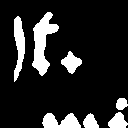

In [16]:
#inverting the ground truth images
gt_set=invert(gt_set)
cv2_imshow(gt_set[0])

In [17]:
#normalizing the pixel values
in_set=in_set/255
gt_set=gt_set/255

In [18]:
#getting the test set
in_test=in_set[4142:4242]
gt_test=gt_set[4142:4242]
in_set=in_set[0:4142]
gt_set=gt_set[0:4142]

In [24]:
#transferring all the tensors to the gpu
in_test=torch.tensor(in_test,device=device,dtype=torch.float32)
gt_test=torch.tensor(gt_test,device=device,dtype=torch.long)
in_set=torch.tensor(in_set,device=device,dtype=torch.float32)
gt_set=torch.tensor(gt_set,device=device,dtype=torch.long)

In [20]:
#preparation for training
lr=0.005 #learning rate
batch_size=32

loss_func=nn.CrossEntropyLoss()
opti=optim.Adam(model.parameters(),lr=lr)

torch.Size([32, 1, 128, 128])


In [ ]:
#training the model for num_epochs
num_epochs=10
for epoch in range(num_epochs):
  #perm=torch.randperm(in_set.size()[0])
  #perm=perm-1
  n=in_set.size()[0]
  print(epoch)
  for i in range(0,n,batch_size):
    opti.zero_grad()
    #indices=perm[i:i+batch_size]
    
    X=in_set[i:i+batch_size]
   
    scores=model.forward(X)
    loss=loss_func(scores,gt_set[i:i+batch_size])

    loss.backward()
    opti.step()

    if i%1024 is 0:
      print(loss.item())

0
0.3729095458984375
0.3510158360004425
0.3784761130809784
0.4287142753601074
0.45006120204925537
1
0.4334586560726166
0.3476353585720062
0.3706762194633484
0.4222213625907898
0.4353606402873993
2
0.40946850180625916
0.34251296520233154
0.3607695996761322
0.4103763997554779
0.41698190569877625
3
0.39938995242118835
0.3387882113456726
0.35122430324554443
0.40702199935913086
0.40725311636924744
4
0.3816050589084625
0.33448824286460876
0.35472288727760315
0.4146418273448944
0.40042322874069214
5
0.38085880875587463
0.34413260221481323


In [ ]:
# torch.save(model.state_dict(),'/content/drive/My Drive/Siddharth-Binarization/model_deconv_20eps_AG.pt')


In [ ]:
#checking accuracy
x=model.forward(in_test[0:32])
a,b=torch.max(x.data,dim=1,keepdims=True)
sz=b.shape[0]
num=0
for i in range(sz):
  num=num+b[i][0].eq(gt_test[i]).sum().item()
denom+=sz*128*128
print(num/denom)

In [ ]:
print(num/denom)

0.03078369140625


In [51]:
#loading the wrights
m1=torch.load('/content/drive/My Drive/Siddharth-Binarization/model_deconv_5eps.pt')

In [ ]:
# m2=unet()
model.load_state_dict(m1)
model.to(device)

In [27]:
get_hr=glob.glob('/content/drive/My Drive/Siddharth-Binarization/hand_written/*')

In [28]:
#getting the handwritten image
in_wr=cv2.imread(get_hr[0],cv2.IMREAD_GRAYSCALE)
gt_wr=cv2.imread(get_hr[1],cv2.IMREAD_GRAYSCALE)

In [29]:
in_wr=np.array(in_wr)
gt_wr=np.array(gt_wr)

In [30]:
in_wr,_,_=add_border(in_wr)
gt_wr,_,_=add_border(gt_wr)

In [31]:
iwr_set=split_img(in_wr)
iwr_set=np.array(iwr_set)
gwt_set=split_img(gt_wr)
gwt_set=np.array(gwt_set)

In [32]:
print(gt_wr.shape)

(512, 640)


In [33]:
iwr_set=np.resize(iwr_set,(iwr_set.shape[0],1,iwr_set.shape[1],iwr_set.shape[2]))

In [34]:
iwr_set=torch.tensor(iwr_set,device=device,dtype=torch.float32)

In [35]:
#gt_wr=np.resize(gt_wr,(1,in_wr.shape[0],in_wr.shape[1]))

In [36]:
gt_wr=torch.tensor(gt_wr,device=device,dtype=torch.long)

In [ ]:
iwr_set/=255
x=model.forward(iwr_set)
a,b=torch.max(x.data,dim=1,keepdims=True)
for ind in range(20):
  cv2_imshow(np.array((b[ind][0].cpu())*255))

In [ ]:
a=torch.tensor([1,2,3])
a.append([4,5,6])

In [41]:
#function to generate a binarized image, given the gray scale image
def predict(mode,image,device):
  #print(image.shape)
  image,_,_=add_border(image)
  image=image/255
 # print(image.shape)
  H=image.shape[0]
  W=image.shape[1]
  
  img_set=split_img(image)
  img_set=np.array(img_set)
  # print(img_set.shape)
  img_set=np.resize(img_set,(img_set.shape[0],1,img_set.shape[1],img_set.shape[2]))
  img_set=torch.tensor(img_set,device=device,dtype=torch.float32)
  
  predict=model.forward(img_set)
  predict.to('cpu')
  
  r=predict.shape[0]
  _,b=torch.max(predict.data,dim=1,keepdims=True)
  #print(b.shape)
  b=b.cpu()
  predictions=[]
  for i in range(r):
    #print(i)
    predictions.append(b[i][0]*255)
  #print(H,W)
  i=0
  j=0
  k=0
  ret=np.zeros((H,W))
  #print(ret.shape)
  while i<H :
    j=0
    while j<W:
      #print(ret[i:i+128,j:j+128].shape)
      ret[i:i+128,j:j+128]=predictions[k]
      #print(k)
      k=k+1
      j+=128
    i+=128
  return ret

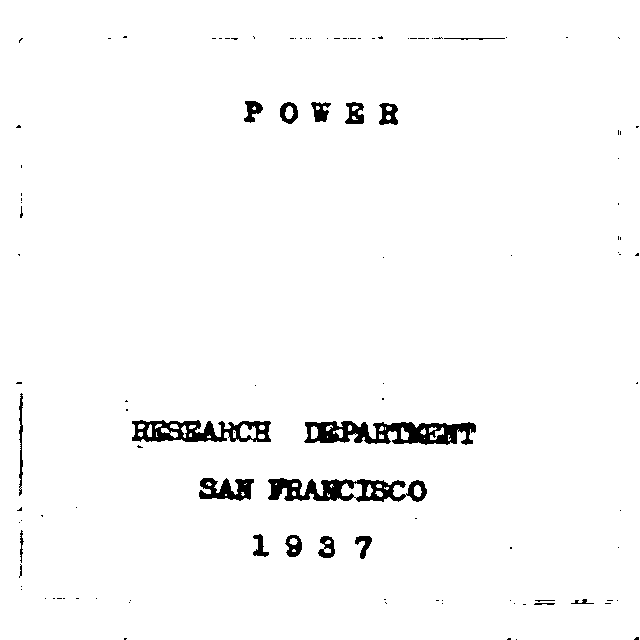

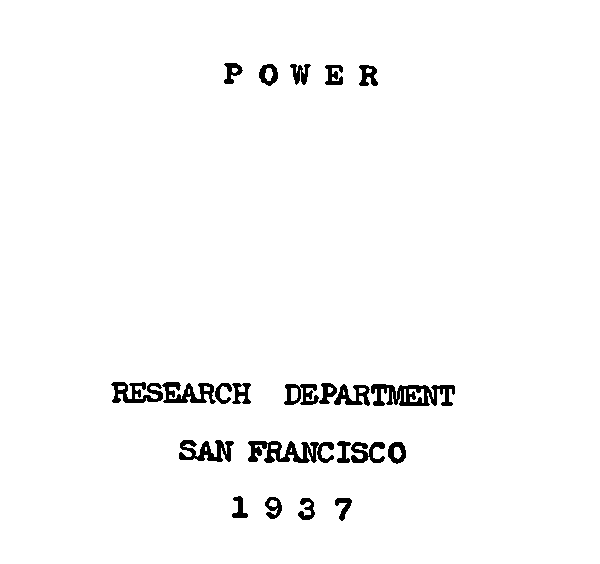

In [53]:
#displaying a test image
#please run this cell after loading the model weights and loading the images, you can change the value of ind variable to change images
ind=6
disp=255-predict(model,images_in[ind],device)
cv2_imshow(disp)
cv2_imshow(images_gt[ind])

In [ ]:
gim,_,_=add_border(gt_wr)
gim=invert(gim)

In [ ]:
r=predict(model,in_wr,device)
cv2_imshow(255-r)
cv2_imshow(gim)

In [55]:
def accuracy(img1,img2):
  img1=torch.tensor(img1)
  img2=torch.tensor(img2)
  num=img1.eq(img2).sum().item()
  denom=img1.shape[0]*img1.shape[1]
  ans=num/denom
  return ans

In [ ]:
ind=33
disp=255-predict(model,images_in[ind],device)
tar,_,_=add_border(images_gt[ind%31])
print(accuracy(disp,tar))